# **Introdução ao objetivo**

1. Introdução e Objetivo
Conceito: Esta seção define o contexto e o problema. No caso do CMU Movie Summary Corpus, o dataset contém sinopses de filmes, metadados (como gêneros, títulos, datas) e outras informações. O objetivo pode variar dependendo do que você deseja prever. Como exemplo, vamos assumir que queremos prever o gênero do filme com base na sinopse, um problema de classificação de texto (multilabel, já que um filme pode ter múltiplos gêner)


### **Importação de ferramentas**

In [151]:
# import libs
import pandas as pd
import matplotlib.pyplot as plt

import ssl
import seaborn as sns
import numpy as np
import os 
import re
import nltk
import json
import joblib

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
from transformers import BertTokenizer

In [154]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


nltk.download('stopwords')
nltk.download('punkt') 

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


False

### **Carregamento de arquivos**

**Descrição:**

Conforme o passado sobre o desafio técnico foi abordado, que é de minha maneira a organização do `notbook`, abordei de maneira simples um `helper`, para o carregamento dos arquivos.

In [109]:
def load_dataframe(filename: str, sep: str = ',', header=None, folder: str = 'data') -> pd.DataFrame:
    """
        Carregamento automatico do `.csv`
    Args:
        filename (str): Nome do arquivo database.
        sep (str): Separador do CSV (padrão ','), mas como estou lidaando com words sera o `\t`.
        header: Linha do cabeçalho ('infer' por padrão) mas estou passando None.
        folder (str): Nome da pasta onde os dados estão armazenados, e está ignorando pelo o gitignore.
    Returns:
        pd.DataFrame: DataFrame carregado.
    """
    try:
        base_path = os.path.join(os.getcwd(), folder)
        full_path = os.path.join(base_path, filename)

        df = pd.read_csv(full_path, sep=sep, header=header)
        return df

    except Exception as e:
        print(f"Error processing files, {filename}: {e}")
        return None


### **Carregamento de dataframes**

In [110]:
movie_metadata = load_dataframe(filename='movie.metadata.tsv', sep='\t', header=None)

In [111]:
summaries = load_dataframe(filename='plot_summaries.txt', sep='\t', header=None)

In [112]:
character = load_dataframe(filename='character.metadata.tsv', sep='\t', header=None)

In [113]:
movie_metadata.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [114]:
summaries.head()

,0,1
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


### **Tratamento de dados**

In [115]:
def clean_character_data(df: str) -> pd.DataFrame:
    """
        __clean_character_data__
        Acrescentando as colunas no dataframe de acordo com o dict
    Args:
        df (str): _description_

    Returns:
        pd.DataFrame: _description_
    """
    rename_map = {
        0: 'movie_id',
        1: 'freebase_id',
        2: 'release_date',
        3: 'character_name',
        4: 'actor_birth_date',
        5: 'actor_gender',
        6: 'actor_height_m',
        7: 'actor_ethnicity_id',
        8: 'actor_name',
        9: 'actor_age_at_release',
        10: 'freebase_character_actor_map_id',
        11: 'freebase_character_id',
        12: 'freebase_actor_id'
    }
    df = df.rename(columns=rename_map)
    return df

def clean_movie_metadata(df: str) -> pd.DataFrame:
    """
        __clean_movie_metadata__
        Acrescentando as colunas no dataframe de acordo com o dict
    Args:
        df (str): passando para acresentar as colunas no dataframe

    Returns:
        pd.DataFrame: Dataframe alterado
    """
    rename_map = {
        0: 'wikipedia_id',
        1: 'freebase_id',
        2: 'name',
        3: 'release_date',
        4: 'box_office',
        5: 'runtime',
        6: 'languages',
        7: 'countries',
        8: 'freebase_character_map'
    }
    df = df.rename(columns=rename_map)
    return df

def clean_summaries_data(df: str) -> pd.DataFrame:
    """
        __clean_summaries_data
        Acrescentando as colunas no dataframe de acordo com o dict
    Args:
        df (str): passando para acresentar as colunas no dataframe
    Returns:
        pd.DataFrame: Dataframe alterado
    """
    rename_map = {
        0: 'movie_id',
        1: 'summary',
    }
    df = df.rename(columns=rename_map)
    return df

In [116]:
movie_metadata = clean_movie_metadata(movie_metadata)
summaries = clean_summaries_data(summaries)
character = clean_character_data(character)

In [118]:
data = pd.merge(character[['movie_id', 'character_name', 'actor_gender']], summaries, on='movie_id')

Dataset combinado com gêneros:
   movie_id              character_name          actor_name  wikipedia_id  \
0    975900                    Akooshay      Wanda De Jesus        975900   
1    975900  Lieutenant Melanie Ballard  Natasha Henstridge        975900   
2    975900         Desolation Williams            Ice Cube        975900   
3    975900          Sgt Jericho Butler       Jason Statham        975900   
4    975900             Bashira Kincaid         Clea DuVall        975900   

                                              genres  
0  [Thriller, Science Fiction, Horror, Adventure,...  
1  [Thriller, Science Fiction, Horror, Adventure,...  
2  [Thriller, Science Fiction, Horror, Adventure,...  
3  [Thriller, Science Fiction, Horror, Adventure,...  
4  [Thriller, Science Fiction, Horror, Adventure,...  


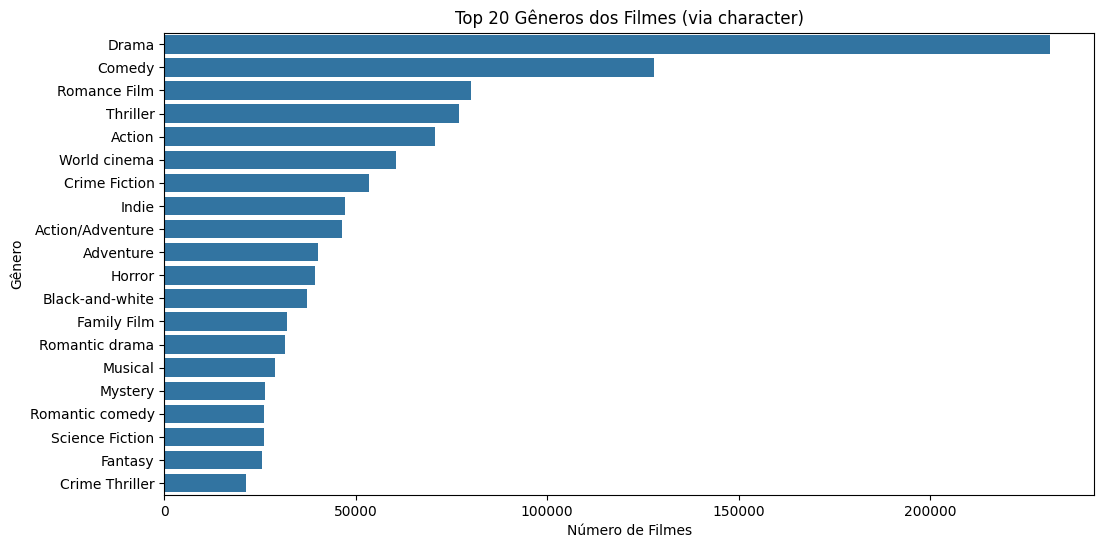

In [132]:
movie_metadata.columns = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 
                 'box_office', 'runtime', 'languages', 'countries', 'freebase_character_map']

# Converter gêneros (JSON para lista)
import json

def parse_genres(json_str):
    try:
        genres_dict = json.loads(json_str)
        return list(genres_dict.values())
    except json.JSONDecodeError:
        return []

movie_metadata['genres'] = movie_metadata['freebase_character_map'].apply(parse_genres)

# Juntar character com movie_metadata
merged_data = pd.merge(character[['movie_id', 'character_name', 'actor_name']], 
                      movie_metadata[['wikipedia_id', 'genres']], 
                      left_on='movie_id', 
                      right_on='wikipedia_id', 
                      how='left')

# Visualizar
print("Dataset combinado com gêneros:")
print(merged_data.head())

# Contar frequência dos gêneros
all_genres = [genre for sublist in merged_data['genres'].dropna() for genre in sublist]
from collections import Counter
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Visualizar top 20 gêneros
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Genre', data=genre_df.head(20))
plt.title('Top 20 Gêneros dos Filmes (via character)')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.savefig('genre_distribution.png')
plt.show()


## Análise Exploratória de Dados

### 1. Distribuição de Gêneros
Analisamos a frequência dos gêneros para identificar desbalanceamento.



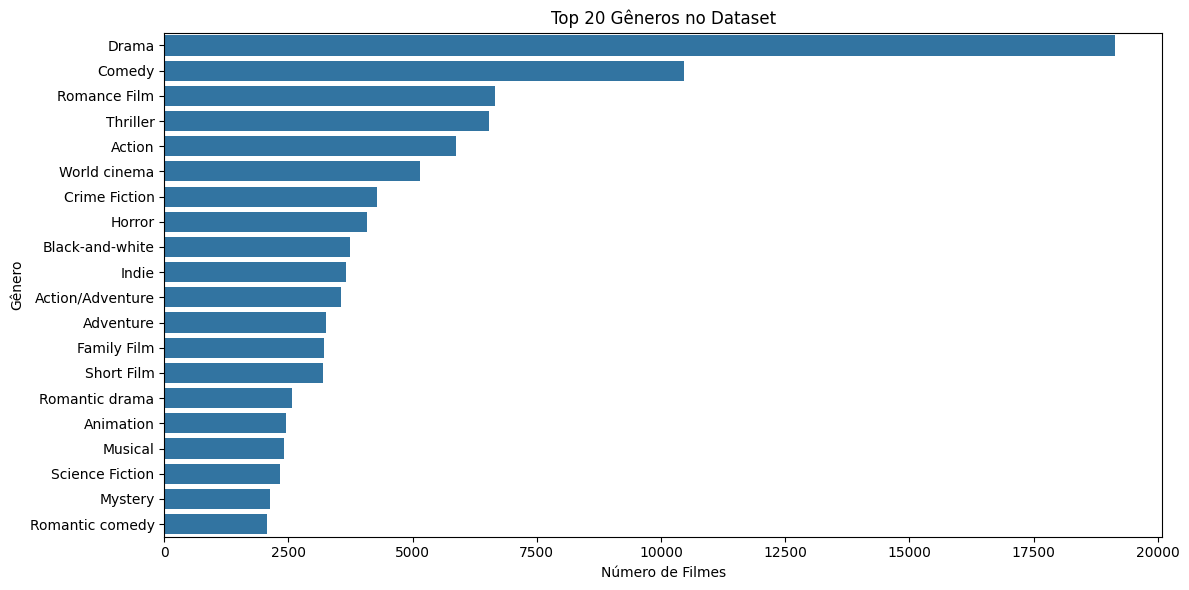


### 2. Comprimento das Sinopses
Verificamos o número de palavras por sinopse para planejar o pré-processamento.



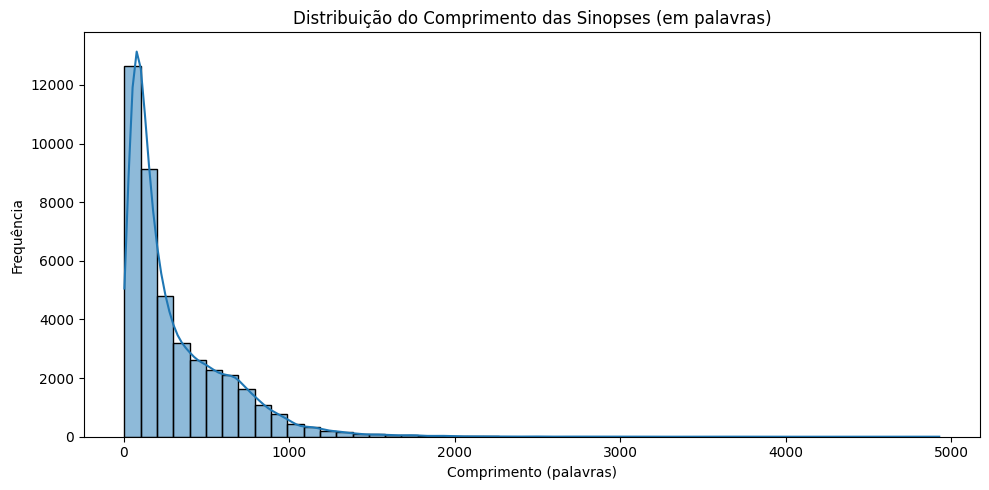


### 3. Nuvem de Palavras
Exploramos os termos mais frequentes nas sinopses.



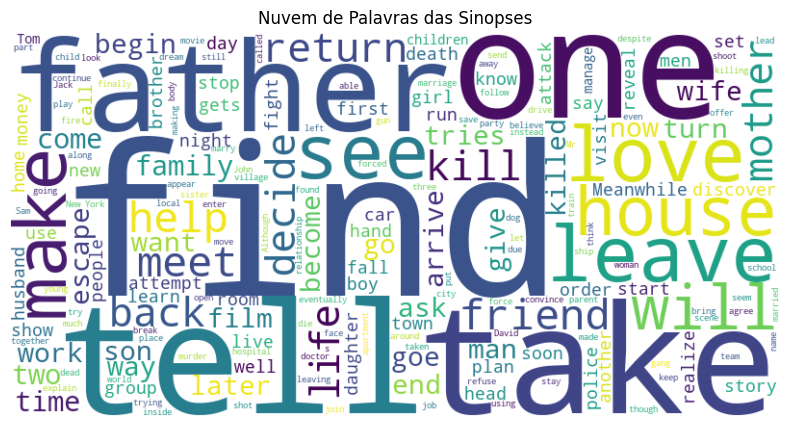


### 4. Dados Faltantes
Checamos por valores ausentes.

Dados faltantes:
 movie_id          0
summary           0
wikipedia_id      0
genres            0
summary_length    0
dtype: int64


In [133]:
# Converter gêneros (JSON para lista)
def parse_genres(json_str):
    try:
        genres_dict = json.loads(json_str)
        return list(genres_dict.values())
    except json.JSONDecodeError:
        return []

movie_metadata['genres'] = movie_metadata['freebase_character_map'].apply(parse_genres)

# Juntar datasets
data = pd.merge(summaries, movie_metadata[['wikipedia_id', 'genres']], 
                left_on='movie_id', right_on='wikipedia_id', how='inner')

# Remover linhas com gêneros vazios
data = data[data['genres'].apply(len) > 0]

# Markdown para documentar
print("""
## Análise Exploratória de Dados

### 1. Distribuição de Gêneros
Analisamos a frequência dos gêneros para identificar desbalanceamento.
""")

# Contar gêneros
all_genres = [genre for sublist in data['genres'] for genre in sublist]
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Genre', data=genre_df.head(20))
plt.title('Top 20 Gêneros no Dataset')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.tight_layout()
plt.savefig('genre_distribution.png')
plt.show()

print("""
### 2. Comprimento das Sinopses
Verificamos o número de palavras por sinopse para planejar o pré-processamento.
""")

# Comprimento das sinopses
data['summary_length'] = data['summary'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(data['summary_length'], bins=50, kde=True)
plt.title('Distribuição do Comprimento das Sinopses (em palavras)')
plt.xlabel('Comprimento (palavras)')
plt.ylabel('Frequência')
plt.tight_layout()
plt.savefig('summary_length.png')
plt.show()

print("""
### 3. Nuvem de Palavras
Exploramos os termos mais frequentes nas sinopses.
""")

# Nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['summary']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras das Sinopses')
plt.savefig('wordcloud.png')
plt.show()

print("""
### 4. Dados Faltantes
Checamos por valores ausentes.
""")

# Dados faltantes
print("Dados faltantes:\n", data.isnull().sum())

In [148]:
nltk.download('punkt')  # Para word_tokenize
stop_words = set(stopwords.words('english'))

# Função para converter gêneros (JSON → lista)
def parse_genres(json_str):
    if pd.isna(json_str):
        return []
    try:
        genres_dict = json.loads(json_str)
        return list(genres_dict.values())
    except (json.JSONDecodeError, TypeError):
        return []

# Aplicar transformação de gêneros
movie_metadata['genres'] = movie_metadata['freebase_character_map'].apply(parse_genres)

# Juntar datasets
data = pd.merge(
    summaries,
    movie_metadata[['wikipedia_id', 'genres']],
    left_on='movie_id',
    right_on='wikipedia_id',
    how='inner'
)

# Remover linhas inválidas
data = data[data['genres'].apply(len) > 0]
data = data.dropna(subset=['summary'])

# Função de limpeza de texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Aplicar limpeza de texto
data['clean_summary'] = data['summary'].apply(clean_text)

# Codificação multilabel dos gêneros
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['genres'])
joblib.dump(mlb, 'mlb.pkl')  # Salvar binarizador

# Vetorização TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(data['clean_summary'])
joblib.dump(tfidf, 'tfidf.pkl')  # Salvar vetorizer

# Divisão de dados (TF-IDF)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

# Tokenização com BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text, max_length=128):
    return tokenizer(text, padding='max_length', truncation=True, 
                     max_length=max_length, return_tensors='pt')

# Aplicar tokenização BERT (linha por linha)
data['tokens'] = data['clean_summary'].apply(lambda x: tokenize_text(x))

# Divisão de dados (BERT)
train_idx, test_idx = train_test_split(data.index, test_size=0.2, random_state=42)
train_data = data.loc[train_idx]
test_data = data.loc[test_idx]

# Verificações finais
print("Shape de X_tfidf:", X_tfidf.shape)
print("Shape de y:", y.shape)
print("Exemplo de gêneros codificados:", mlb.classes_[:5])

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/hedrispereira/nltk_data'
    - '/Users/hedrispereira/temp/joyn-rh-machine-learning/.venv/nltk_data'
    - '/Users/hedrispereira/temp/joyn-rh-machine-learning/.venv/share/nltk_data'
    - '/Users/hedrispereira/temp/joyn-rh-machine-learning/.venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************
